## Import necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

C:\Users\anany\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Preprocessing

#### Load the dataset

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=15

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

#### Explore the dataset

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[14  9 14  6  3  0  7  6  3 11  9  8  5  3  3  5  5  9 10  6 14 14  2  2
 14  6  5  2  9 12  2  8]


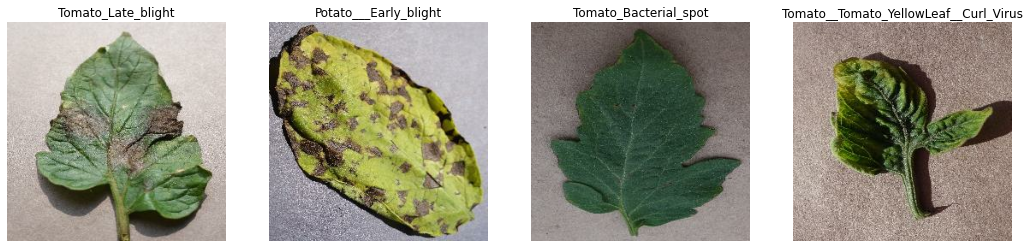

In [6]:
plt.figure(figsize=(18, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)


645

#### Split the dataset into train, validation, test sets

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

516

In [11]:
len(val_ds)

64

In [12]:
len(test_ds)

65

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### Data Augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building

### 1. Customized CNN model

In [59]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [60]:
input_shape

(32, 256, 256, 3)

In [61]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_20 (Conv2D)          (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d_20 (MaxPooli  (32, 127, 127, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (32, 60, 60, 64)         

In [62]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [63]:
model.compile

<bound method Model.compile of <keras.src.engine.sequential.Sequential object at 0x000001AA6EA944F0>>

#### Train the model

In [64]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
516/516 [==============================] - 1005s 2s/step - loss: 1.9900 - accuracy: 0.3413 - val_loss: 1.6182 - val_accuracy: 0.4741
Epoch 2/15
516/516 [==============================] - 948s 2s/step - loss: 1.2016 - accuracy: 0.5873 - val_loss: 1.1608 - val_accuracy: 0.5898
Epoch 3/15
516/516 [==============================] - 982s 2s/step - loss: 0.8516 - accuracy: 0.7031 - val_loss: 0.7353 - val_accuracy: 0.7324
Epoch 4/15
516/516 [==============================] - 947s 2s/step - loss: 0.6644 - accuracy: 0.7663 - val_loss: 0.8225 - val_accuracy: 0.7266
Epoch 5/15
516/516 [==============================] - 908s 2s/step - loss: 0.5572 - accuracy: 0.8020 - val_loss: 0.6628 - val_accuracy: 0.7661
Epoch 6/15
516/516 [==============================] - 908s 2s/step - loss: 0.4929 - accuracy: 0.8273 - val_loss: 1.1289 - val_accuracy: 0.7031
Epoch 7/15
516/516 [==============================] - 964s 2s/step - loss: 0.4247 - accuracy: 0.8537 - val_loss: 0.5791 - val_accuracy: 0.813

#### Plot the Training and Validation accuracy and loss

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

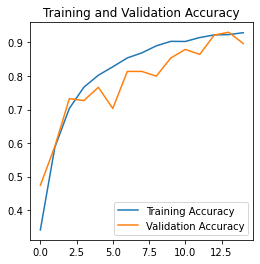

In [66]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

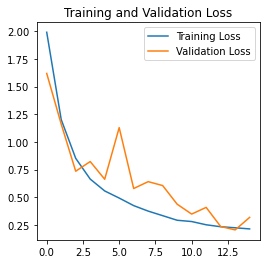

In [67]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Test the model on test set

#### Function 

In [17]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Testing

1/1 [==============================] - 0s 52ms/step


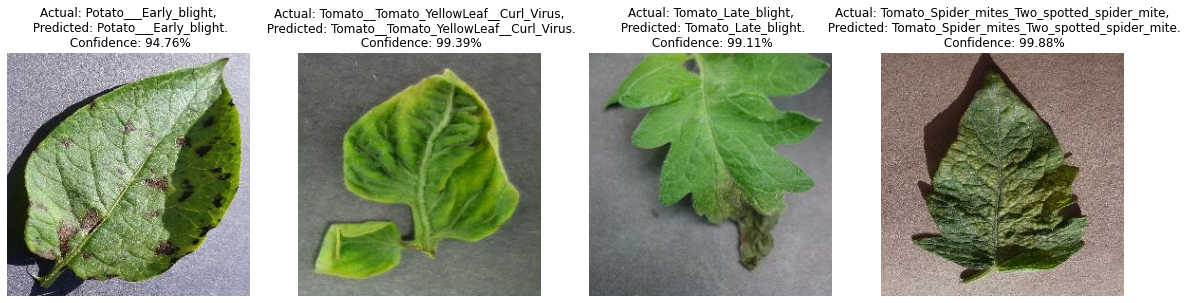

In [69]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Evaluate the model

In [70]:
model.evaluate(test_ds)

65/65 [==============================] - 28s 437ms/step - loss: 0.3533 - accuracy: 0.8822


[0.35331985354423523, 0.8822115659713745]

### 2. ResNet50V2 Model

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model1 = models.Sequential(resize_and_rescale)
base_model1 = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape = (256,256,3),
    pooling='avg',
    classes=15,
    weights="imagenet"
)

for layer in base_model1.layers:
    layer.trainable = False
    
model1.add(base_model1)
model1.add(layers.Flatten())
model1.add(layers.Dense(128,activation='relu'))
model1.add(layers.Dense(64,activation='relu'))
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(64,activation='relu'))
model1.add(layers.Dense(n_classes, kernel_regularizer = tf.keras.regularizers.l2(0.01), activation='softmax'))

model1.build(input_shape=input_shape)

In [19]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (32, 2048)                0         
                                                                 
 dense (Dense)               (32, 128)                 262272    
                                                                 
 dense_1 (Dense)             (32, 64)                  8256      
                                                                 
 dense_2 (Dense)             (32, 256)                 16640     
                                                                 
 dense_3 (Dense)             (32, 64)                 

In [20]:
model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

#### Training

In [21]:
history1=model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15)

Epoch 1/15
516/516 [==============================] - 1240s 2s/step - loss: 0.9184 - accuracy: 0.7411 - val_loss: 0.6080 - val_accuracy: 0.8193
Epoch 2/15
516/516 [==============================] - 1137s 2s/step - loss: 0.4963 - accuracy: 0.8631 - val_loss: 0.4478 - val_accuracy: 0.8706
Epoch 3/15
516/516 [==============================] - 1121s 2s/step - loss: 0.3970 - accuracy: 0.8872 - val_loss: 0.3651 - val_accuracy: 0.8887
Epoch 4/15
516/516 [==============================] - 1135s 2s/step - loss: 0.3436 - accuracy: 0.9032 - val_loss: 0.3814 - val_accuracy: 0.8828
Epoch 5/15
516/516 [==============================] - 1195s 2s/step - loss: 0.3200 - accuracy: 0.9060 - val_loss: 0.3498 - val_accuracy: 0.8940
Epoch 6/15
516/516 [==============================] - 1150s 2s/step - loss: 0.2782 - accuracy: 0.9176 - val_loss: 0.3091 - val_accuracy: 0.8979
Epoch 7/15
516/516 [==============================] - 1130s 2s/step - loss: 0.2636 - accuracy: 0.9210 - val_loss: 0.3020 - val_accuracy:

#### Plot

In [22]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy of ResNet50V2')

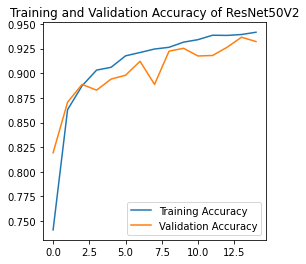

In [23]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of ResNet50V2')

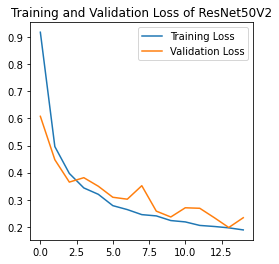

In [24]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of ResNet50V2')
plt.show()

#### Testing

1/1 [==============================] - 0s 133ms/step


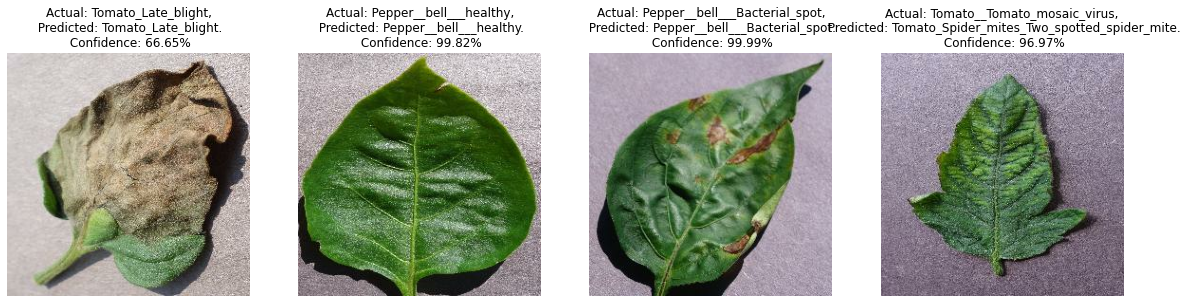

In [25]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model1, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Evaluate

In [26]:
model1.evaluate(test_ds)

65/65 [==============================] - 108s 2s/step - loss: 0.2609 - accuracy: 0.9226


[0.26087096333503723, 0.9225961565971375]

### 3. MobileNetV2 Model

In [51]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model2 = models.Sequential(resize_and_rescale)

base_model2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='max',
    classes=15,
)

for layer in base_model2.layers:
    layer.trainable = False

model2.add(base_model2)
model2.add(layers.Flatten())
model2.add(layers.Dense(128,activation='relu'))
model2.add(layers.Dense(64,activation='relu'))
model2.add(layers.Dense(128,activation='relu'))
model2.add(layers.Dense(64,activation='relu'))
model2.add(layers.Dense(n_classes, activation='softmax'))

model2.build(input_shape=input_shape)

In [52]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_8 (Flatten)         (32, 1280)                0         
                                                                 
 dense_39 (Dense)            (32, 128)                 163968    
                                                                 
 dense_40 (Dense)            (32, 64)                  8256      
                                                                 
 dense_41 (Dense)            (32, 128)                 8320      
                                                     

In [53]:
model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

#### Training

In [54]:
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15)

Epoch 1/15
516/516 [==============================] - 446s 857ms/step - loss: 1.0420 - accuracy: 0.6578 - val_loss: 0.8120 - val_accuracy: 0.7290
Epoch 2/15
516/516 [==============================] - 421s 816ms/step - loss: 0.5918 - accuracy: 0.7986 - val_loss: 0.6590 - val_accuracy: 0.7744
Epoch 3/15
516/516 [==============================] - 447s 866ms/step - loss: 0.4816 - accuracy: 0.8359 - val_loss: 0.5465 - val_accuracy: 0.8120
Epoch 4/15
516/516 [==============================] - 462s 895ms/step - loss: 0.4473 - accuracy: 0.8470 - val_loss: 0.4949 - val_accuracy: 0.8359
Epoch 5/15
516/516 [==============================] - 452s 875ms/step - loss: 0.4180 - accuracy: 0.8572 - val_loss: 0.6157 - val_accuracy: 0.7856
Epoch 6/15
516/516 [==============================] - 444s 861ms/step - loss: 0.4009 - accuracy: 0.8619 - val_loss: 0.4944 - val_accuracy: 0.8296
Epoch 7/15
516/516 [==============================] - 425s 823ms/step - loss: 0.3866 - accuracy: 0.8680 - val_loss: 0.5726 -

#### Plot

In [69]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy of MobileNetV2')

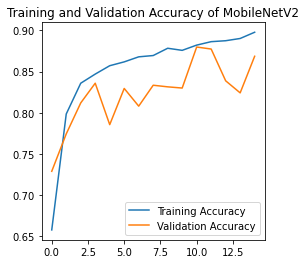

In [70]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of MobileNetV2')

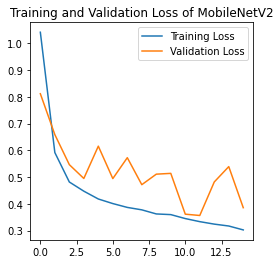

In [71]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of MobileNetV2')
plt.show()

#### Testing

1/1 [==============================] - 0s 110ms/step


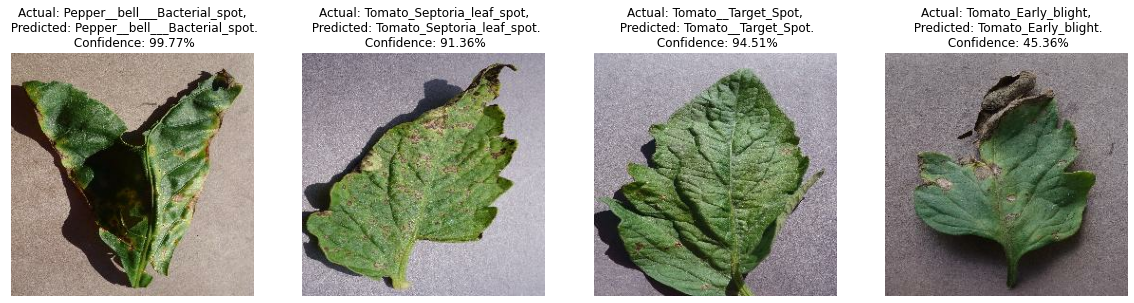

In [58]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model2, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Evaluate

In [59]:
model2.evaluate(test_ds)

65/65 [==============================] - 49s 746ms/step - loss: 0.3810 - accuracy: 0.8793


[0.3810023069381714, 0.8793269395828247]

### 4. InceptionV3

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model3 = models.Sequential(resize_and_rescale)

base_model3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='max',
    classes=15,
)

for layer in base_model3.layers:
    layer.trainable = False
    
model3.add(base_model3)
model3.add(layers.Flatten())
model3.add(layers.Dense(128,activation='relu'))
model3.add(layers.Dense(64,activation='relu'))
model3.add(layers.Dense(256,activation='relu'))
model3.add(layers.Dense(64,activation='relu'))
model3.add(layers.Dense(n_classes, kernel_regularizer = tf.keras.regularizers.l2(0.01), activation='softmax'))

model3.build(input_shape=input_shape)

In [29]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_3 (Flatten)         (32, 2048)                0         
                                                                 
 dense_14 (Dense)            (32, 128)                 262272    
                                                                 
 dense_15 (Dense)            (32, 64)                  8256      
                                                                 
 dense_16 (Dense)            (32, 256)                 16640     
                                                                 
 dense_17 (Dense)            (32, 64)                 

In [30]:
model3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

#### Training

In [33]:
history3=model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15)

Epoch 1/15
516/516 [==============================] - 1211s 2s/step - loss: 1.0745 - accuracy: 0.6627 - val_loss: 0.9724 - val_accuracy: 0.7021
Epoch 2/15
516/516 [==============================] - 1363s 3s/step - loss: 0.8600 - accuracy: 0.7304 - val_loss: 0.7942 - val_accuracy: 0.7461
Epoch 3/15
516/516 [==============================] - 1136s 2s/step - loss: 0.7381 - accuracy: 0.7622 - val_loss: 0.6787 - val_accuracy: 0.7905
Epoch 4/15
516/516 [==============================] - 912s 2s/step - loss: 0.6993 - accuracy: 0.7758 - val_loss: 0.7590 - val_accuracy: 0.7578
Epoch 5/15
516/516 [==============================] - 828s 2s/step - loss: 0.6665 - accuracy: 0.7855 - val_loss: 0.6824 - val_accuracy: 0.7822
Epoch 6/15
516/516 [==============================] - 832s 2s/step - loss: 0.6191 - accuracy: 0.8009 - val_loss: 0.6262 - val_accuracy: 0.8022
Epoch 7/15
516/516 [==============================] - 818s 2s/step - loss: 0.5899 - accuracy: 0.8122 - val_loss: 0.6022 - val_accuracy: 0.8

#### Plot

In [34]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy of InceptionV3')

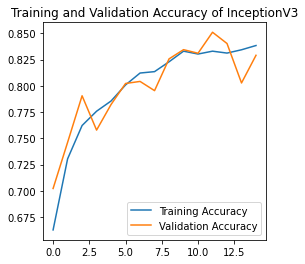

In [35]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of InceptionV3')

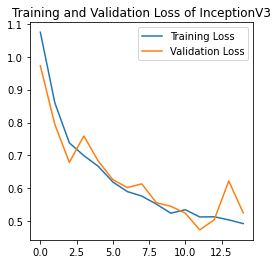

In [36]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of InceptionV3')
plt.show()

#### Testing

1/1 [==============================] - 0s 99ms/step


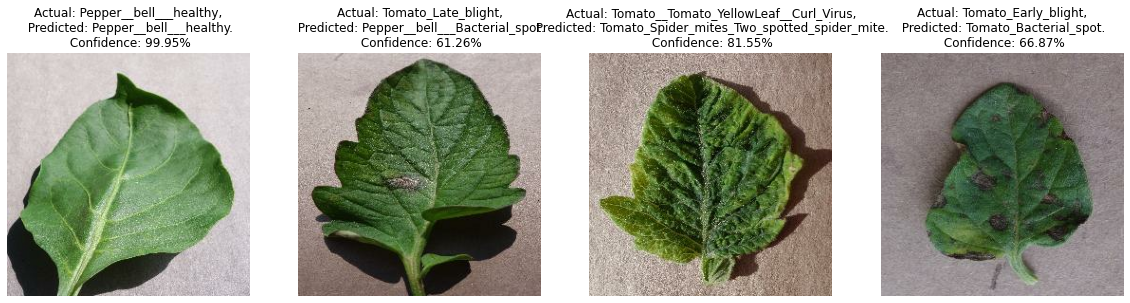

In [38]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model3, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Evaluate

In [39]:
model3.evaluate(test_ds)

65/65 [==============================] - 88s 1s/step - loss: 0.5304 - accuracy: 0.8226


[0.530351996421814, 0.8225961327552795]

### 5. Ensemble Model

In [60]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

models = [model2, model3]
model_input = Input(shape=(256,256,3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [61]:
ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

#### Training

In [63]:
history4=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15)

Epoch 1/15
516/516 [==============================] - 1158s 2s/step - loss: 0.3346 - accuracy: 0.9069 - val_loss: 0.3987 - val_accuracy: 0.8823
Epoch 2/15
516/516 [==============================] - 1196s 2s/step - loss: 0.3354 - accuracy: 0.9079 - val_loss: 0.4957 - val_accuracy: 0.8594
Epoch 3/15
516/516 [==============================] - 1128s 2s/step - loss: 0.3270 - accuracy: 0.9106 - val_loss: 0.4077 - val_accuracy: 0.8882
Epoch 4/15
516/516 [==============================] - 1144s 2s/step - loss: 0.3238 - accuracy: 0.9089 - val_loss: 0.5156 - val_accuracy: 0.8467
Epoch 5/15
516/516 [==============================] - 1283s 2s/step - loss: 0.3026 - accuracy: 0.9168 - val_loss: 0.4037 - val_accuracy: 0.8892
Epoch 6/15
516/516 [==============================] - 1255s 2s/step - loss: 0.3208 - accuracy: 0.9076 - val_loss: 0.3597 - val_accuracy: 0.8945
Epoch 7/15
516/516 [==============================] - 1157s 2s/step - loss: 0.3049 - accuracy: 0.9144 - val_loss: 0.3249 - val_accuracy:

#### Plot

In [64]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy of Ensemble model')

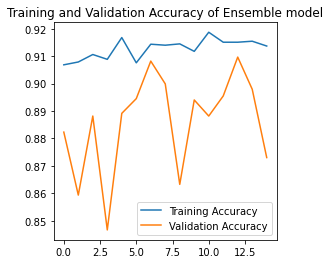

In [65]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of Ensemble model')

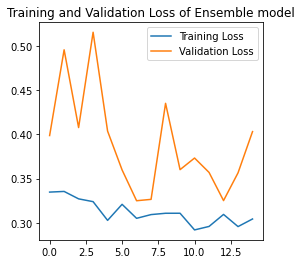

In [66]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of Ensemble model')
plt.show()

#### Testing

1/1 [==============================] - 0s 80ms/step


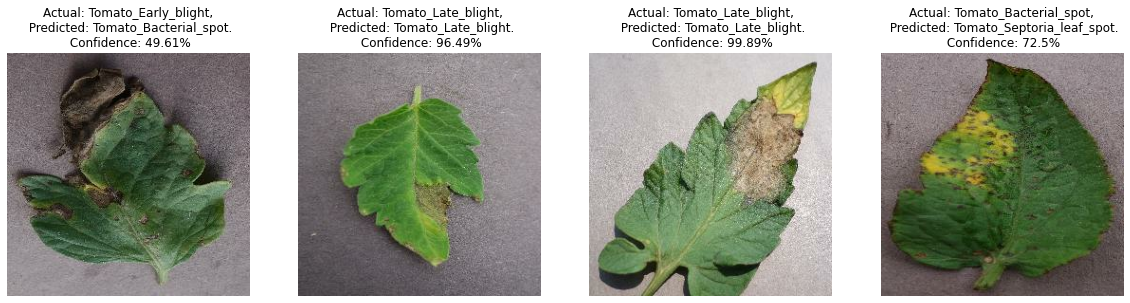

In [67]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(ensemble_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Evaluate

In [68]:
ensemble_model.evaluate(test_ds)

65/65 [==============================] - 119s 2s/step - loss: 0.3863 - accuracy: 0.8808


[0.38629502058029175, 0.8807692527770996]

### 6. NasNetMobile

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model5 = models.Sequential(resize_and_rescale)

base_model5 = tf.keras.applications.NASNetMobile(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='max',
    classes=15,
)

for layer in base_model5.layers:
    layer.trainable = False
    
model5.add(base_model5)
model5.add(layers.Flatten())
model5.add(layers.Dense(128,activation='relu'))
model5.add(layers.Dense(64,activation='relu'))
model5.add(layers.Dropout(0.3))
model5.add(layers.Dense(256,activation='relu'))
model5.add(layers.Dense(64,activation='relu'))
model5.add(layers.Dense(n_classes, activation='softmax'))

model5.build(input_shape=input_shape)

In [26]:
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 NASNet (Functional)         (None, 1056)              4269716   
                                                                 
 flatten_3 (Flatten)         (32, 1056)                0         
                                                                 
 dense_12 (Dense)            (32, 128)                 135296    
                                                                 
 dense_13 (Dense)            (32, 64)                  8256      
                                                                 
 dropout (Dropout)           (32, 64)                  0         
                                                                 
 dense_14 (Dense)            (32, 256)                

In [27]:
model5.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [28]:
history5=model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15)

Epoch 1/15
516/516 [==============================] - 751s 1s/step - loss: 1.5637 - accuracy: 0.4885 - val_loss: 1.0108 - val_accuracy: 0.6680
Epoch 2/15
516/516 [==============================] - 785s 2s/step - loss: 0.9962 - accuracy: 0.6660 - val_loss: 0.8664 - val_accuracy: 0.7158
Epoch 3/15
516/516 [==============================] - 697s 1s/step - loss: 0.8539 - accuracy: 0.7179 - val_loss: 0.7682 - val_accuracy: 0.7520
Epoch 4/15
516/516 [==============================] - 703s 1s/step - loss: 0.7782 - accuracy: 0.7386 - val_loss: 0.7661 - val_accuracy: 0.7363
Epoch 5/15
516/516 [==============================] - 710s 1s/step - loss: 0.7099 - accuracy: 0.7684 - val_loss: 0.6645 - val_accuracy: 0.7734
Epoch 6/15
516/516 [==============================] - 707s 1s/step - loss: 0.6654 - accuracy: 0.7850 - val_loss: 0.6204 - val_accuracy: 0.7925
Epoch 7/15
516/516 [==============================] - 701s 1s/step - loss: 0.6388 - accuracy: 0.7879 - val_loss: 0.6026 - val_accuracy: 0.7998

#### Plot

In [29]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy of NasNetMobile')

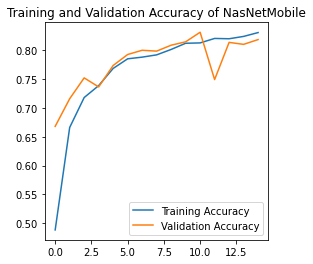

In [30]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of NasNetMobile')

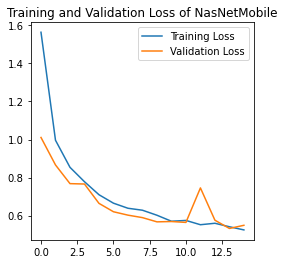

In [31]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of NasNetMobile')
plt.show()

#### Testing

1/1 [==============================] - 0s 228ms/step


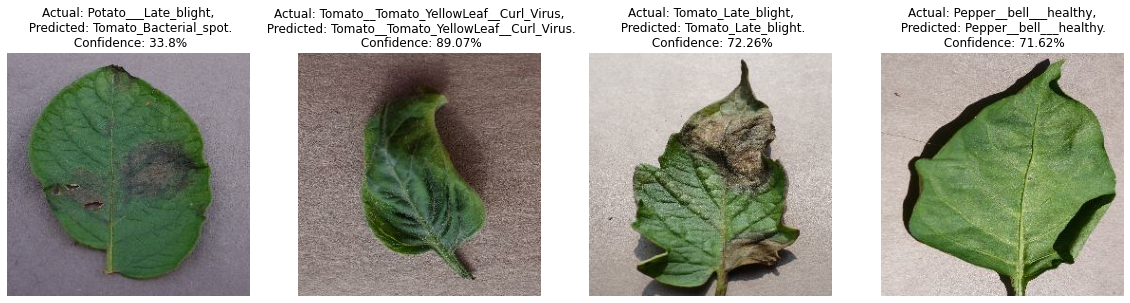

In [32]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model5, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Evaluate

In [33]:
model5.evaluate(test_ds)

65/65 [==============================] - 106s 2s/step - loss: 0.5403 - accuracy: 0.8207


[0.5403419733047485, 0.8206730484962463]